In [1]:
# Modify the file A00_setup.  Note the working directory is changed
import os
os.chdir(os.getcwd().rsplit(os.path.sep + 'code')[0] + os.path.sep + 'code')
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./A_target_count_encoding/A00_setup.py").load_module()
os.getcwd()

'/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code'

# XGBoost, Target Encoding all Feeatures: Vary blending midpoint.
No blending of hierarchy, just target encode all of the NAICS hierarchy features (separately).  Vary the parameter lambda_k, the blending midpoint

*This script takes about 5 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import pickle

In [3]:
from pathlib import Path

In [4]:
import sklearn as sk
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance, partial_dependence
from scikitplot.metrics import plot_lift_curve

In [5]:
from sba_gnn.sba_gnn import sg_plot, sg_blender
# Hierarchical encoder on one feature is just regular target encoding
from sba_gnn.sba_gnn.sg_blender import HierarchicalEncoder 

In [6]:
sg_plot.plot_defaults()

## Import Processed Datasets

In [7]:
sba_loans = pd.read_parquet(Path(setup.parent_path).joinpath('01_DATA_transformed.parquet')) 

In [8]:
best_params_df = pd.read_csv(Path(setup.parent_path).joinpath('03_REPORT_fit_parameter_selected.csv'))
best_params = best_params_df.to_dict(orient='records')[0]
best_params

{'subsample': 0.8,
 'scale_pos_weight': 1.0,
 'reg_lambda': 0.01,
 'reg_alpha': 0.001,
 'min_child_weight': 50,
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 2}

In [9]:
xgb_params = dict(best_params, 
                   **{'objective':"binary:logistic", 'n_estimators':setup.xgb_n_estimators})

##### Comparison metrics

In [10]:
metrics_base = pd.read_csv(Path(setup.parent_path).joinpath('13_REPORT_metrics.csv'))

In [11]:
# Standard target encoding
metrics_tenc = pd.read_csv(Path(setup.parent_path).joinpath('14_REPORT_metrics.csv'))

In [12]:
# Target+Count
metrics_tc = pd.read_csv(Path(setup.temp_path).joinpath('A04_REPORT_metrics.csv'))

In [13]:
# Target-Thresh
metrics_tt = pd.read_csv(Path(setup.temp_path).joinpath('A10_REPORT_metrics.csv'))

## Function to get metrics

In [14]:
def get_metrics(data, lambda_k = setup.selected_lambda_k,
                enc_features = ['NAICS', 'NAICS_5', 'NAICS_4', 'NAICS_3', 'NAICS_sector']):
    
    # Alternative encoding
    train_df = data[data['dset'] == 'train']
    enc_dict = {f:HierarchicalEncoder(lambda_k = lambda_k) for f in enc_features}
    [enc_dict[f].fit(train_df[[f]], train_df['target']) for f in enc_features]
    enc_val = pd.concat([enc_dict[f].transform(data[[f]]) for f in enc_features],
                    axis=1, keys=enc_features)
    
    # Append to data
    data = pd.concat([data.drop(columns=enc_val.columns, errors='ignore'), enc_val], 
                      axis=1)
    train_df = data[data['dset'] == 'train']
    test_df = data[data['dset'] == 'test']
    val_df = data[data['dset'] == 'val']
    
    predictor_features = setup.predictor_features + list(enc_val.columns)

    # Model fit
    xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators =  setup.xgb_n_estimators)
    xgb_model = xgb_model.set_params(**xgb_params)
    xgb_model.fit(train_df[predictor_features], train_df['target'],
              eval_set = [(train_df[predictor_features], train_df['target']),
                         (val_df[predictor_features], val_df['target'])])
    
    # Predict
    pred_df = pd.concat([data[['LoanNr_ChkDgt', 'dset', 'target', 'dset_naics_holdout']].reset_index(),
                     pd.DataFrame({'predict_prob':
                                   xgb_model.predict_proba(data[predictor_features])[:,1]})],
                    axis=1) \
    .set_index('index')
    
    # Decision threshold
    pred_train_df = pred_df[pred_df['dset'] == 'train']
    thresh_tune_data = sg_plot.get_f1_frame(pred_train_df['target'], 
                                        pred_train_df['predict_prob'])
    thresh_head = thresh_tune_data.sort_values('f1', ascending=False).head(2)
    best_thresh = thresh_head['thresh'].iloc[0]
    pred_df['predict_bin'] = np.where(pred_df['predict_prob'] >= best_thresh, 1, 0)
    
    # Metrics
    metrics_dset_df = pred_df.groupby('dset') \
        .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()
    metrics_test_df = pred_df[pred_df['dset'] == 'test'] \
        .groupby(['dset', 'dset_naics_holdout']) \
        .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()
    metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
    
    return pred_df, metrics_df

## Loop to get predictions, metrics

In [15]:
count_sets = [5, 10, 20, 50, 100, 200, 500, 1000, 2000]

In [16]:
%%capture
pred_df = pd.DataFrame()
metrics_df = pd.DataFrame()
for c in count_sets:
    this_pred, this_met = get_metrics(sba_loans, c)
    this_pred['c'] = c
    pred_df = pd.concat([pred_df, this_pred])
    this_met['c'] = c
    metrics_df = pd.concat([metrics_df, this_met])

In [17]:
metrics_df[metrics_df['dset_naics_holdout'] == 1]

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout,c
1,test,0.679364,0.420901,0.313262,0.641232,0.350896,0.731138,1.0,5
1,test,0.667512,0.420336,0.307626,0.663396,0.351460,0.730734,1.0,10
1,test,0.676582,0.423478,0.313189,0.653667,0.352911,0.732386,1.0,20
1,test,0.678211,0.424965,0.314661,0.654344,0.353793,0.734072,1.0,50
1,test,0.657074,0.427883,0.307019,0.705693,0.360323,0.736726,1.0,100
1,test,0.632048,0.424726,0.296639,0.747483,0.364460,0.737115,1.0,200
1,test,0.701454,0.428003,0.328303,0.614669,0.362745,0.739286,1.0,500
1,test,0.694737,0.434148,0.327332,0.644446,0.366439,0.741626,1.0,1000
1,test,0.690463,0.431251,0.323708,0.645800,0.366389,0.740451,1.0,2000


In [18]:
metrics_df[metrics_df['dset_naics_holdout'] == 0]

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout,c
0,test,0.660938,0.451431,0.338298,0.678250,0.387491,0.730624,0.0,5
0,test,0.659986,0.451892,0.338030,0.681423,0.386984,0.730563,0.0,10
0,test,0.660147,0.451290,0.337843,0.679446,0.387368,0.730623,0.0,20
0,test,0.661538,0.453101,0.339333,0.681631,0.386627,0.730863,0.0,50
0,test,0.660489,0.452467,0.338532,0.681996,0.387535,0.730731,0.0,100
0,test,0.661110,0.451917,0.338598,0.679238,0.387147,0.730144,0.0,200
0,test,0.656904,0.451597,0.336400,0.686781,0.385640,0.729731,0.0,500
0,test,0.656230,0.450492,0.335584,0.685065,0.382209,0.728651,0.0,1000
0,test,0.651618,0.448898,0.332706,0.689799,0.378153,0.726718,0.0,2000


In [19]:
pred_df.to_parquet(Path(setup.temp_path).joinpath('A30_DATA_combined_predictions.parquet'))
metrics_df.to_csv(Path(setup.temp_path).joinpath('A30_REPORT_metrics.csv'), index=True)

## Compare Results to Standard

In [20]:
metrics_sum_dict = {'menc':metrics_tenc,
                    'mhier':metrics_base,
                    'menc_all': metrics_df,
                    'tc': metrics_tc,
                    'tt': metrics_tt}

In [21]:
def make_plot(sum_dict, holdout_val, 
              hline_val = None,
              yfeature = 'average_precision_score', ylabel = 'PR-AUC',
              title = None, titlesize = 16, legendsize = 12,
              ax = None):
    m_dict = {k: v[v['dset_naics_holdout'] == holdout_val] for k, v in sum_dict.items()}
    return sg_plot.curve_compare_hline(m_dict, hline_val=hline_val,
                                       style_dict =setup.model_label_styles,
                                       color_dict = setup.model_label_colors,
                                       label_dict = setup.model_label_dict,
                                       xfeature = 'c',
                                       yfeature = yfeature,
                                       xlabel='blend midpoint or count threshold',
                                       ylabel = ylabel,
                                       titlesize = titlesize,
                                       legendsize = legendsize,
                                       title = title,
                                      ax=ax)

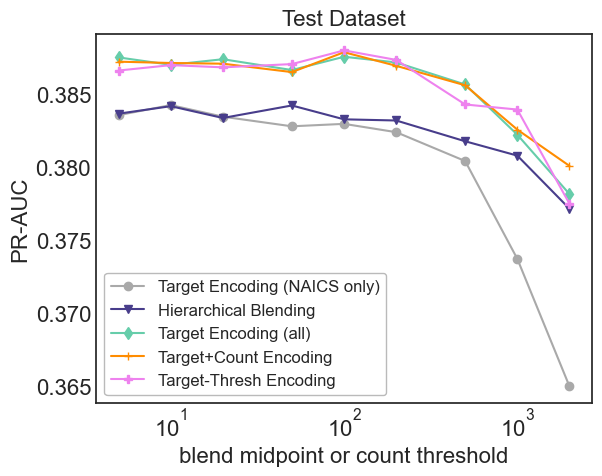

In [22]:
fig = make_plot(metrics_sum_dict, 0, 
                title='Test Dataset')
#plt.gca().legend(frameon=True, fontsize=12).set_bbox_to_anchor((0.9, 0.4))
fig.savefig(Path(setup.temp_path).joinpath('A30_PLOT_compare_base_reg.png'),
            bbox_inches='tight')

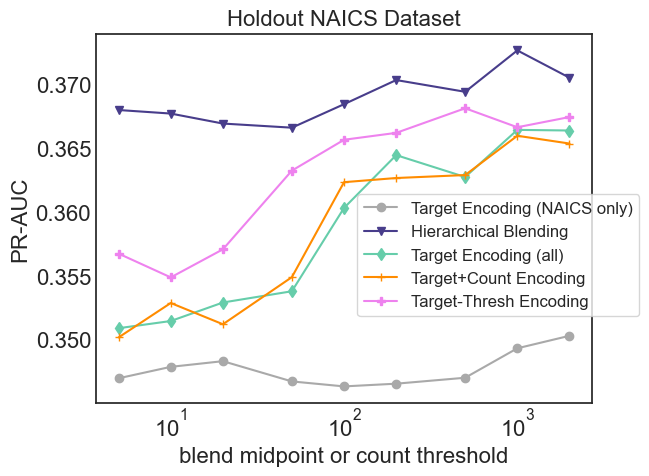

In [23]:
fig = make_plot(metrics_sum_dict, 1, 
                title='Holdout NAICS Dataset')
plt.gca().legend(frameon=True, fontsize=12).set_bbox_to_anchor((0.51, 0.4))
fig.savefig(Path(setup.temp_path).joinpath('A30_PLOT_compare_base_ho.png'),
            bbox_inches='tight')

##### Combined plot

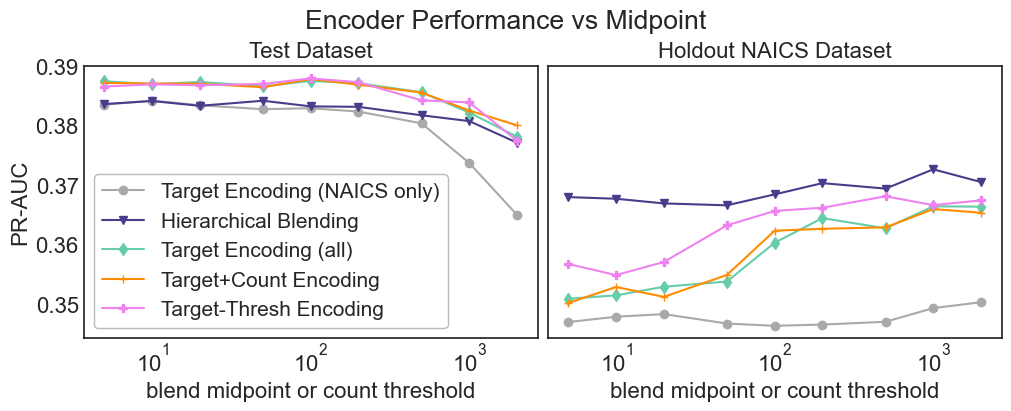

In [24]:
# Combined plot
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True,
                      figsize = (10,4), layout='constrained')
make_plot(metrics_sum_dict, 0, 
                title='Test Dataset',
         ax=ax[0],
         legendsize=15)
make_plot(metrics_sum_dict, 1,
                title='Holdout NAICS Dataset',
         ax=ax[1])
ax[1].legend().set_visible(False)
fig.suptitle('Encoder Performance vs Midpoint')
fig.savefig(Path(setup.temp_path).joinpath('A30_PLOT_compare_base_combined.png'),
            bbox_inches='tight')